# BOVW
### Workflow:
- loading data
- extracting key points
- clustering

In [75]:
import cv2
import numpy as np
import os

In [76]:
''' It returns:
Since the Folders with the images have the following structure:
- ROOT
-- Parasitized
-- Uninfected
I need to construct the corrisponding label
'''
train_path = '../cell_images'  
training_names = [name for name in os.listdir(train_path) if name != '.DS_Store']
image_paths = []
image_classes = []
class_id = 0

def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

''' It returns:
- image_paths: list of paths to all the images
- image_classes: list of labels
'''

for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

Let's extract descriptors!

In [81]:
des_list = []

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
brisk = cv2.BRISK_create(30)

rm_indexes = []

index = 0
for image_path in image_paths:
    im = cv2.imread(image_path)
    if im is not None:
        im_resized = cv2.resize(im, (128, 128))
        kpts, des = brisk.detectAndCompute(im_resized, None)
        if des is not None:
            des_list.append((image_path, des))
        else:
            print("here the descriptor is None",image_path)
            rm_indexes.append(index)
    else:
        print("the not loaded image is",image_path)
        rm_indexes.append(index)
    index+=1

the not loaded image is ../cell_images/Parasitized/Thumbs.db
here the descriptor is None ../cell_images/Parasitized/C136P97ThinF_IMG_20151005_143743_cell_113.png
here the descriptor is None ../cell_images/Parasitized/C116P77ThinF_IMG_20150930_171448_cell_117.png
here the descriptor is None ../cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_134112_cell_145.png
here the descriptor is None ../cell_images/Parasitized/C189P150ThinF_IMG_20151203_142224_cell_82.png
here the descriptor is None ../cell_images/Parasitized/C116P77ThinF_IMG_20150930_171954_cell_90.png
here the descriptor is None ../cell_images/Parasitized/C133P94ThinF_IMG_20151004_155518_cell_117.png
here the descriptor is None ../cell_images/Parasitized/C80P41ThinF_IMG_20150817_112329_cell_20.png
here the descriptor is None ../cell_images/Parasitized/C189P150ThinF_IMG_20151203_141809_cell_90.png
here the descriptor is None ../cell_images/Parasitized/C182P143NThinF_IMG_20151201_171905_cell_176.png
here the descriptor is None ..

In [82]:
## Let's remove the noise
for el in rm_indexes:
    image_classes.pop(el)

In [83]:
## Let's remove the noise
for el in rm_indexes:
    image_paths.pop(el)

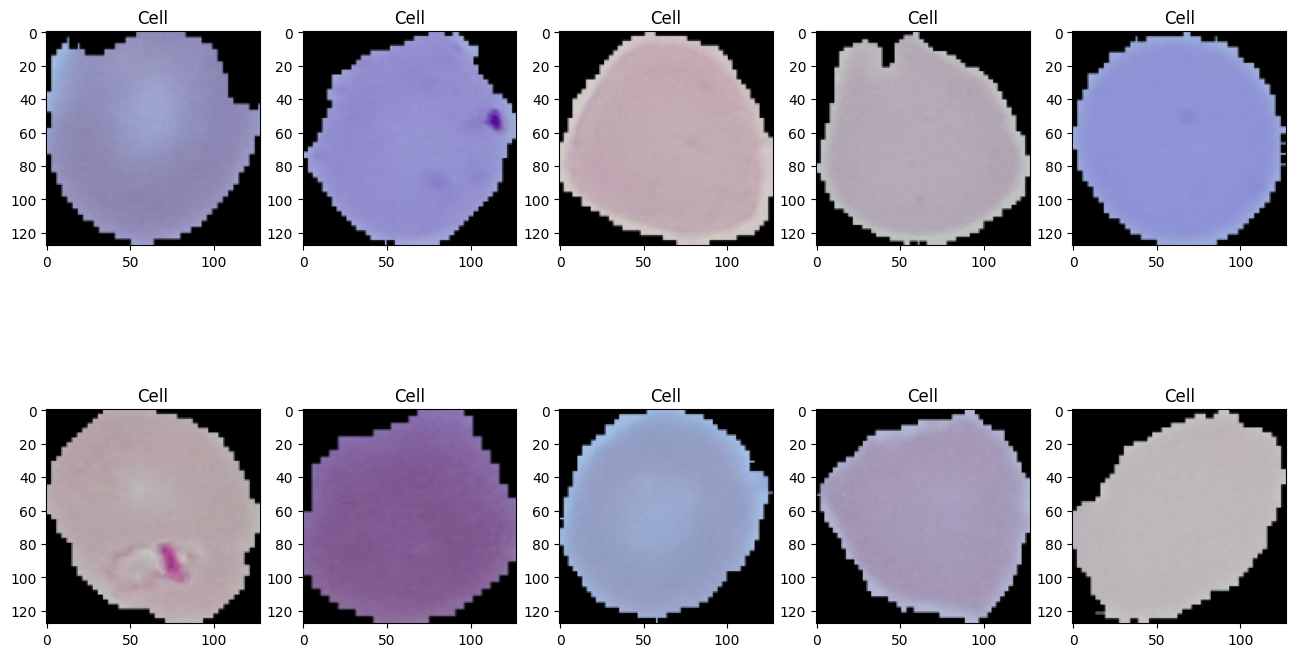

In [84]:
import matplotlib.pyplot as plt
def  plot_random(path_images, num = 5):
    indices = np.random.choice(len(path_images),num*2,replace=False)

    plt.figure(figsize=(16,9))
    for i in range(num * 2): ## matplotlib starts from 1 differently from when using python
        plt.subplot(2,num, i+1) # 2 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("Cell")
        path_img = path_images[indices[i]]
        img = cv2.imread(path_img)  # Reads in BGR format (the output is in BRG) 
        im_resized = cv2.resize(img, (128, 128))
        plt.imshow(im_resized )
    
plot_random(image_paths, num = 5)

In [85]:
len(image_classes)

27505

In [86]:
len(des_list)

27505

In [87]:
from sklearn.model_selection import train_test_split
Des_train, Des_test, y_train, y_test = train_test_split(des_list, image_classes, test_size=0.2, random_state=42)

## Training:

Now i stack the descriptors vertically (adding rows one after the other)

In [88]:
descriptors = Des_train[0][1]
for image_path, descriptor in Des_train[1:]:
    descriptors = np.vstack((descriptors, descriptor))  

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float) 

## Let's perform K-means!

In [89]:
# Perform k-means clustering and vector quantization
'''kmeans returns:
- codebook: A k by N array of k centroids (vocabulary).
- distortion: The mean (non-squared) Euclidean distance between the observations passed and the centroids generated
'''
from scipy.cluster.vq import kmeans, vq

k = 200  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(descriptors_float, k, 1) 

## Remarks:
- number of clusters is the number of visual words in the vocabulary

# Vector Quantization!

- Vector quantization is a process where vectors (in this case, feature descriptors of an image) are mapped to a finite number of vectors (called codebook vectors or centroids) in a lower-dimensional space. 
- The vq function takes two main arguments: the vectors to be quantized and the codebook vectors.

In [90]:
''' vq returns:
- words: an array containing the indices of the centroids (visual words) for each descriptors. Given K descriptors for an image i have K indices
- distance: an array of distances. measures how well the centroid represent the descriptor
'''
im_features = np.zeros((len(Des_train), k), "float32")
for i in range(len(Des_train)):
    words, distance = vq(Des_train[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [91]:
print("the input shape is:",im_features.shape)
print("the number of labels is:",len(image_classes))

the input shape is: (22004, 200)
the number of labels is: 27505


In [92]:
'''-nbr_occurences: is obtained summing up each column to see how many times a centroid is chosen to describe the descriptor
- idf is the IDF weights for each centroid (visual word)
'''
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

In [93]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

## Pass the features to a classifier!

In [94]:
from sklearn.svm import LinearSVC
clf = LinearSVC(max_iter=10000)  #Default of 100 is not converging
clf.fit(im_features,y_train)

/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=10000)

In [95]:
import joblib
#Joblib dumps Python object into one file
joblib.dump((clf, training_names, stdSlr, k, voc), "bovw.pkl", compress=3)  

['bovw.pkl']

# Validation:

In [96]:
clf, classes_names, stdSlr, k, voc = joblib.load("bovw.pkl")

In [97]:
test_features = np.zeros((len(Des_test), k), "float32")
for i in range(len(Des_test)):
    words, distance = vq(Des_test[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [98]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

In [99]:
test_features = stdSlr.transform(test_features)

In [100]:
#Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in y_test]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]

In [101]:
len(predictions)

5501

In [102]:
len(true_class)

5501

accuracy =  0.712961279767315


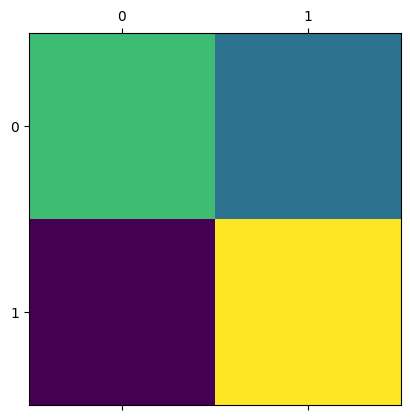

In [103]:
from sklearn.metrics import confusion_matrix, accuracy_score #sreeni
import pylab as pl
accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions)
pl.matshow(cm)
pl.show()